# Feature Description

## Status
0: 1-29 days past due \
1: 30-59 days past due \
2: 60-89 days overdue \
3: 90-119 days overdue \
4: 120-149 days overdue \
5: Overdue or bad debts, write-offs for more than 150 days \
C: paid off that month \
X: No loan for the month

## Target
0: Normal Borrower \
1: Risky Borrower

# Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import psycopg2 as pg
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', palette = 'Paired')
#plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
np.set_printoptions(suppress=True) # Suppress scientific notation where possible
from ipywidgets import interactive, FloatSlider

from sklearn.inspection import permutation_importance
from sklearn import linear_model, svm, naive_bayes, neighbors, ensemble
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix,\
roc_auc_score, roc_curve, precision_recall_curve, f1_score, fbeta_score, recall_score,\
precision_recall_fscore_support

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)
from sklearn.metrics import accuracy_score, make_scorer, log_loss

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from mlxtend.plotting import plot_decision_regions

import xgboost as xgb

# Import Data

In [2]:
df = pd.read_csv('/Users/dominguez/Documents/Loan_Decision_Bot/data/credit_card_approval.csv', low_memory=False)

# Data Exploration

In [ ]:
df.head()

In [ ]:
plt.hist(df['TARGET']);

In [ ]:
# Highly imbalanced

Several columns are negative values, which is weird. Let's fix them so they're positive values and are on adequate scale

In [3]:
# Convert to positive values
df['DAYS_BIRTH'] = df['DAYS_BIRTH'] * -1
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'] * -1
df['BEGIN_MONTHS'] = df['BEGIN_MONTHS'] * -1

# Replace Y with 1 and N with 0 to have quantify features
df.replace({'FLAG_OWN_CAR': {'Y':1, 'N':0}, 'FLAG_OWN_REALTY': {'Y':1, 'N':0}}, inplace=True)

# Then convert to adequate scale that makes sense
df['DAYS_BIRTH'] = round(df['DAYS_BIRTH'] / 365,2)
df['DAYS_EMPLOYED'] = round(df['DAYS_EMPLOYED'] / 365,2)

# Rename the columns that have weird names
df.rename(columns={'DAYS_BIRTH': 'AGE'}, inplace=True)
df.rename(columns={'DAYS_EMPLOYED': 'YRS_EMPLOYED'}, inplace=True)
df.rename(columns={'BEGIN_MONTHS': 'MONTHS_LOAN_AGE'}, inplace=True)

# Replace STATUS values

df['STATUS'].replace(to_replace='0', value='1-29 days', inplace=True)
df['STATUS'].replace(to_replace='1', value='30-59 days', inplace=True)
df['STATUS'].replace(to_replace='2', value='60-89 days', inplace=True)
df['STATUS'].replace(to_replace='3', value='90-119 days', inplace=True)
df['STATUS'].replace(to_replace='4', value='120-149 days', inplace=True)
df['STATUS'].replace(to_replace='5', value='150+ days', inplace=True)
df['STATUS'].replace(to_replace='C', value='paid off', inplace=True)
df['STATUS'].replace(to_replace='X', value='no loan', inplace=True)

In [ ]:
plt.head()

In [ ]:
plt.hist(df['AGE']);

In [ ]:
df['AGE'].describe()

In [ ]:
# Age is fairly evenly distributed

In [ ]:
plt.hist(df['CODE_GENDER']);

In [ ]:
plt.hist(df['FLAG_OWN_CAR']);

In [ ]:
plt.hist(df['FLAG_OWN_REALTY']);

In [ ]:
plt.hist(df['AMT_INCOME_TOTAL'], bins=30);

In [ ]:
plt.hist(df['YRS_EMPLOYED']);

In [ ]:
df['JOB'].value_counts()

In [ ]:
plt.hist(df['MONTHS_LOAN_AGE']);

In [ ]:
df['STATUS'].value_counts()

In [ ]:
# Most loans are paid off...

In [ ]:
edu_inc = df.groupby(by='NAME_EDUCATION_TYPE').mean()[['AMT_INCOME_TOTAL']].reset_index().sort_values('AMT_INCOME_TOTAL')

In [ ]:
edu_inc

In [ ]:
e = sns.barplot(edu_inc['NAME_EDUCATION_TYPE'], edu_inc['AMT_INCOME_TOTAL'])
e.set_xticklabels(labels=edu_inc['NAME_EDUCATION_TYPE'],rotation=70);

In [2]:
# There's an interaction happening between education and total income, it seems to be a positive linear correlation

# Feature Selection

There are a lot of features that have no impact on the target variable. Let's select the features that have the highest correlation with the target variable

1. AMT_INCOME_TOTAL
2. YRS_EMPLOYED
3. MONTHS_LOAN_AGE
4. STATUS
5. TARGET
6. FLAG_OWN_CAR
7. FLAG_OWN_REALTY
8. NAME_EDUCATION_TYPE

In [4]:
df = df[['FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_EDUCATION_TYPE','AMT_INCOME_TOTAL', 'YRS_EMPLOYED', 'MONTHS_LOAN_AGE', 'STATUS', 'TARGET']]

In [15]:
df.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,AMT_INCOME_TOTAL,YRS_EMPLOYED,MONTHS_LOAN_AGE,STATUS,TARGET
0,1,0,Secondary / secondary special,270000.0,6.30,6,paid off,0
1,0,0,Secondary / secondary special,81000.0,1.03,4,1-29 days,0
2,1,1,Higher education,270000.0,2.82,0,paid off,0
3,1,1,Secondary / secondary special,112500.0,5.36,3,1-29 days,0
4,1,1,Secondary / secondary special,139500.0,15.28,29,1-29 days,0


In [ ]:
df.corr()

# Base Model

(430133, 16)

In [26]:
# Establish features and target variables

X = df.loc[:,'FLAG_OWN_CAR':'STATUS']
X = X.sample(n=40000)

y = df['TARGET']
y = y.sample(n=40000)

In [27]:
# Encoding categorical variables

categoricals = ['STATUS', 'NAME_EDUCATION_TYPE']
numericals = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'YRS_EMPLOYED', 'MONTHS_LOAN_AGE']

ohe = OneHotEncoder(sparse=False, drop='first')
cat_matrix = ohe.fit_transform(X.loc[:, categoricals])
X_ohe = pd.DataFrame(cat_matrix,
                       columns=ohe.get_feature_names(categoricals), #create meaningful column names
                       index=X.index) #keep the same index values
X = pd.concat([X.loc[:, numericals], X_ohe], axis=1)

In [28]:
# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Split train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=42)

#this helps with the way kf will generate indices below
# X, y = np.array(X), np.array(y)

In [29]:
# Scale features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [30]:
# Validate

# Knn
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled,y_train)
print(f'KNN score: {knn.score(X_val_scaled,y_val)}')

# Logistic Regression
lr = LogisticRegression(penalty='none')
lr.fit(X_train_scaled,y_train)
print(f'Logistic Regression score: {lr.score(X_val_scaled,y_val)}')

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_scaled,y_train)
print(f'Random Forest score: {rf.score(X_val_scaled,y_val)}')

# XGBoost
gbm = xgb.XGBClassifier( )
gbm.fit(X_train_scaled,y_train)
print(f'XGBoost score: {gbm.score(X_val_scaled,y_val)}')

# SVC
svc = SVC(probability=True)
svc.fit(X_train_scaled,y_train)
print(f'SVC score: {svc.score(X_val_scaled,y_val)}')

KNN score: 0.995625
Logistic Regression score: 0.995625
Random Forest score: 0.995375
XGBoost score: 0.995625
SVC score: 0.995625


In [31]:
# Test

# Scale test data

X_test_scaled = scaler.transform(X_test)

# Knn
print(f'KNN test score: {knn.score(X_test_scaled,y_test)}')

# Logistic Regression
print(f'Logistic Regression test score: {lr.score(X_test_scaled,y_test)}')

# Random Forest
print(f'Random Forest test score: {rf.score(X_test_scaled,y_test)}')

# XGBoost
print(f'XGBoost test score: {gbm.score(X_test_scaled,y_test)}')

# SVC
print(f'SVC test score: {svc.score(X_test_scaled,y_test)}')

KNN test score: 0.997375
Logistic Regression test score: 0.997375
Random Forest test score: 0.996875
XGBoost test score: 0.99725
SVC test score: 0.997375


# Model performance

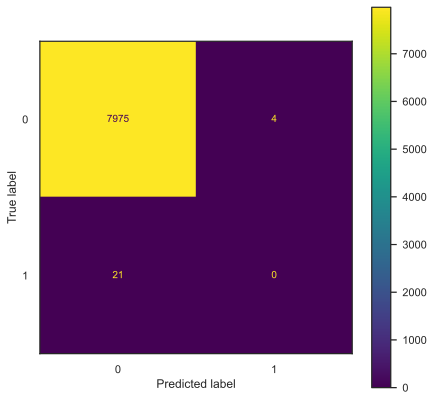

In [32]:
# Random Forest Confusion Matrix

fig, ax = plt.subplots(figsize=(7, 7))
plot_confusion_matrix(rf, X_test_scaled, y_test, ax=ax);